## Interpretation of TF models trained on UniProtKB Coronaviridae S protein dataset for multiclass classification using Saliency Scores

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..']

In [17]:
from prediction.models.nlp import transformer, transformer_model, cnn1d, lstm, fnn
from src.utils import utils, nn_utils
from src.utils.nlp_utils.padding import Padding

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from captum.attr import Saliency, DeepLift, LayerIntegratedGradients, TokenReferenceBase, IntegratedGradients

In [3]:
label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1453,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [4]:
from torch.utils.data import Dataset


class ProteinSequenceDataset(Dataset):
    def __init__(self, df, sequence_col, max_seq_len, truncate, label_col):
        super(ProteinSequenceDataset, self).__init__()
        self.sequence_col = sequence_col
        self.max_seq_len = max_seq_len
        self.label_col = label_col
        self.amino_acid_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                               'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                               'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                               'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                               'J': 26}
        self.data = df
        if truncate:
            self.data = self.truncate_dataset(df)

    def __len__(self) -> int:
        return self.data.shape[0]

    def truncate_dataset(self, df):
        # Truncating sequences to fixed length of sequence_max_length
        df[self.sequence_col] = df[self.sequence_col].apply(lambda x: x[0:self.max_seq_len])
        return df

    def get_labels(self):
        return self.data[self.label_col]

    def __getitem__(self, idx: int):
        # loc selects based on index in df
        # iloc selects based on integer location (0, 1, 2, ...)
        record = self.data.iloc[idx, :]
        sequence = record[self.sequence_col]
        label = record[self.label_col]

        sequence_vector = np.array([self.amino_acid_map[a] for a in sequence])
        label_vector = np.array([label])

        return torch.tensor(sequence_vector, 
                            device=nn_utils.get_device(), 
                            dtype=torch.float64), torch.tensor(label_vector, device=nn_utils.get_device())


In [5]:
def get_token_dataset_loader(df, sequence_settings, label_col):
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))

def load_dataset_with_df(df, sequence_settings):
    df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = get_token_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)

In [6]:
uniprotkb_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts.csv")
uniprotkb_coronaviruses_df.head()

,id,seq,virus,seq_len,virus_host,binary_label
0,A3EX94,MTLLMCLLMSLLIFVRGCDSQFVDMSPASNTSECLESQVDAAAFSK...,Bat coronavirus HKU4 (BtCoV) (BtCoV/HKU4/2004),1352,Tylonycteris pachypus (Lesser bamboo bat) (Ves...,Not Human
1,A3EXD0,MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFES...,Bat coronavirus HKU5 (BtCoV) (BtCoV/HKU5/2004),1352,Pipistrellus abramus (Japanese pipistrelle) (P...,Not Human
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
3,P11223,MLVTPLLLVTLLCALCSAVLYDSSSYVYYYQSAFRPPSGWHLQGGA...,Avian infectious bronchitis virus (strain Beau...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human
4,P12651,MLVTPLLLVTLLCVLCSAALYDSSSYVYYYQSAFRPPNGWHLHGGA...,Avian infectious bronchitis virus (strain M41)...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human


In [7]:
uniprotkb_coronaviruses_df["virus_host"].value_counts()

Sus scrofa (Pig) [TaxID: 9823]                                                                  2620
Homo sapiens (Human) [TaxID: 9606]                                                              2400
Meleagris gallopavo (Wild turkey) [TaxID: 9103]                                                   36
Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]      19
Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]                  17
Gallus gallus (Chicken) [TaxID: 9031]                                                             13
Bos taurus (Bovine) [TaxID: 9913]                                                                 10
Name: virus_host, dtype: int64

In [8]:
uniprotkb_coronaviruses_humans_df = uniprotkb_coronaviruses_df[uniprotkb_coronaviruses_df["virus_host"] == "Homo sapiens (Human) [TaxID: 9606]"]
print(uniprotkb_coronaviruses_humans_df.shape)
uniprotkb_coronaviruses_humans_df.head()

(2400, 6)


,id,seq,virus,seq_len,virus_host,binary_label
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
5,P15423,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...,Human coronavirus 229E (HCoV-229E),1173,Homo sapiens (Human) [TaxID: 9606],Human
12,P36334,MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...,Human coronavirus OC43 (HCoV-OC43),1353,Homo sapiens (Human) [TaxID: 9606],Human
14,Q0ZME7,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N5) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human
15,Q14EB0,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N2) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human


min seq len = 35
max seq len = 1366


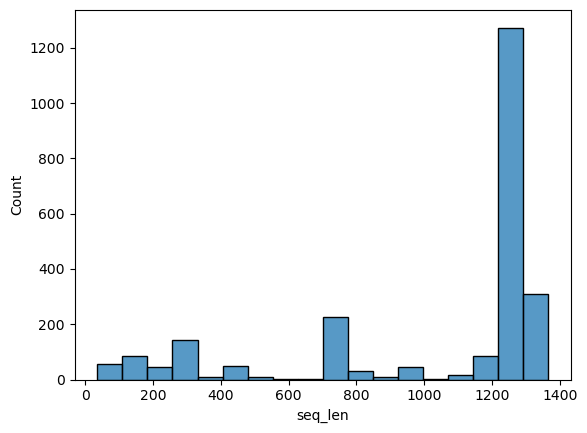

In [9]:
sns.histplot(uniprotkb_coronaviruses_humans_df["seq_len"])
print(f"min seq len = {min(uniprotkb_coronaviruses_humans_df['seq_len'])}")
print(f"max seq len = {max(uniprotkb_coronaviruses_humans_df['seq_len'])}")
plt.show()

In [10]:
index_label_map, coronavirus_dataset_loader = load_dataset_with_df(uniprotkb_coronaviruses_humans_df, test_sequence_settings)
print_dataset_loader(coronavirus_dataset_loader)
# Random seq, label from coronavirus_dataset_loader
coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
[2]


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/tmp/ipykernel_3924/845779479.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

torch.Size([1, 1453])
tensor([[13., 14., 22.,  ...,  0.,  0.,  0.]], device='cuda:0',
       dtype=torch.float64)
torch.Size([1])
tensor([2], device='cuda:0')


### Load the trained model

##### Model: TF trained on Coronaviridae S protein dataset
#### Model: TF - PosEmb_SINCOS - MSL_1024 - d_512
#### Training Dataset: UniProtKB Coronaviridae 5K
#### Manual Seed = 0

In [11]:
model_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230816/host_multi_baseline_focal"

In [22]:
model["kernel_size"] = 3
model["stride"] = 1
model["depth"] = 4
cnn_model = cnn1d.get_cnn_model(model)
cnn_model.load_state_dict(torch.load(os.path.join(model_dir, "cnn-l_4_itr0.pth")))
cnn_model = cnn_model.to(nn_utils.get_device())

CNN_1D_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (conv1d): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden_layers): ModuleList(
    (0-2): 3 x Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  )
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14181895


In [23]:
model["depth"] = 2
lstm_model = lstm.get_lstm_model(model)
lstm_model.load_state_dict(torch.load(os.path.join(model_dir, "lstm-l_2_itr0.pth")))
lstm_model = lstm_model.to(nn_utils.get_device())

LSTM_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14717447


In [24]:
model["depth"] = 10
fnn_model = fnn.get_fnn_model(model)
fnn_model.load_state_dict(torch.load(os.path.join(model_dir, "fnn-l_10_itr0.pth")))
fnn_model = fnn_model.to(nn_utils.get_device())

FNN_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (linear_ip): Linear(in_features=512, out_features=1024, bias=True)
  (linear_hidden): Linear(in_features=1024, out_features=1024, bias=True)
  (linear_hidden_n): ModuleList(
    (0-9): 10 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (linear_op): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  12091911


In [25]:
model["depth"] = 6
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230904/host_multi_baseline_focal_pytorchtf/transformer-l_6-h_8_itr0.pth"
nlp_model_coronaviridae = transformer_model.get_transformer_model(model)
nlp_model_coronaviridae.load_state_dict(torch.load(model_path))
nlp_model_coronaviridae = nlp_model_coronaviridae.to(nn_utils.get_device())


TransformerModel(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=512, out_features=7, bias=True)
)
Number of parameters =  12634119


### Prediction Performance

In [14]:
def validate(model, dataset_loader):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df["y_true"] = labels.cpu().numpy()
            results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [25]:
results = validate(nlp_model_coronaviridae, coronavirus_dataset_loader)

In [30]:
index_label_map

{0: 'Bovine',
 1: 'Chicken',
 2: 'Human',
 3: 'Japanese pipistrelle',
 4: 'Lesser bamboo bat',
 5: 'Pig',
 6: 'Wild turkey'}

In [34]:
results_df = results.rename(columns=index_label_map)
results_df["y_true"] = results_df["y_true"].map(lambda x: index_label_map[x])
results_df

,Bovine,Chicken,Human,Japanese pipistrelle,Lesser bamboo bat,Pig,Wild turkey,y_true
0,0.009269,0.003829,0.909964,0.002700,0.020296,0.000029,0.053912,Human
1,0.009764,0.003731,0.909157,0.002866,0.021172,0.000030,0.053281,Human
2,0.003933,0.363466,0.250910,0.002976,0.006701,0.300310,0.071703,Human
3,0.009451,0.003829,0.909095,0.002748,0.020634,0.000029,0.054213,Human
4,0.006680,0.004134,0.917927,0.001995,0.015391,0.000027,0.053846,Human
...,...,...,...,...,...,...,...,...
2395,0.003224,0.393320,0.252757,0.002440,0.005823,0.263034,0.079401,Human
2396,0.017362,0.005303,0.844665,0.004939,0.036343,0.000037,0.091352,Human
2397,0.046468,0.011549,0.591894,0.013795,0.090605,0.000068,0.245622,Human
2398,0.006362,0.004318,0.916721,0.001909,0.014835,0.000027,0.055828,Human


In [36]:
auprcs = []
for i in index_label_map.values():
    precision, recall, _ = precision_recall_curve(y_true=results_df["y_true"].values, probas_pred=results_df[i].values, pos_label=i)
    auprc = auc(recall, precision)
    print(f"AUPRC for class {i} = {auprc}")
    auprcs.append(auprc)

macro_auprc = mean(auprcs)
print(f"Macro AUPRC = {macro_auprc}")

AUPRC for class Bovine = 0.5
AUPRC for class Chicken = 0.5
AUPRC for class Human = 1.0
AUPRC for class Japanese pipistrelle = 0.5
AUPRC for class Lesser bamboo bat = 0.5
AUPRC for class Pig = 0.5
AUPRC for class Wild turkey = 0.5
Macro AUPRC = 0.5714285714285714


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No posit

In [88]:
rbd_positions = [332,333,334,335,337,339,340,344,345,346,347,348,349,351,352,354,356,359,362,364,366,367,370,371,372,373,375,376,378,380,381,382,384,385,388,389,390,393,394,395,396,397,399,401,402,403,404,405,406,407,410,411,412,413,414,415,417,418,419,420,424,425,426,427,428,430,431,432,433,434,435,436,437,438,439,440,441,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,489,490,491,493,494,495,496,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524]
rbm_positions = range(438, 506)

### DeepLift

In [19]:
# Random seq, label from coronavirus_dataset_loader
coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))

In [18]:
token_reference = TokenReferenceBase(reference_token_idx=1)
reference_seq = token_reference.generate_reference(sequence_length=model["max_seq_len"], device=nn_utils.get_device()).unsqueeze(0)


In [17]:
# forward pass to calculate predictions
prediction = nlp_model_coronaviridae(coronavirus_seq)
print(prediction.shape)
prediction

torch.Size([1, 7])


tensor([[-2.3686,  1.9885,  1.8744, -2.4675, -2.1405,  0.6874,  2.1386]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [18]:
# get index of class with highest prediction score
max_pred_score, max_pred_index = torch.max(prediction, dim=1)
print(f"max_pred_score = {max_pred_score}, max_pred_index={max_pred_index}")

max_pred_score = tensor([2.1386], device='cuda:0', grad_fn=<MaxBackward0>), max_pred_index=tensor([6], device='cuda:0')


In [19]:
# backward pass on the maximum prediction score to get gradients of score predicted class w.r.t. input image

max_pred_score.backward()

In [20]:
print(coronavirus_seq.grad)

None


In [26]:
dl = LayerIntegratedGradients(cnn_model, cnn_model.embedding)
attributions = []
for i in range(1):
    coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))
    attribution = dl.attribute(coronavirus_seq, reference_seq, target=2)
    attribution = attribution.sum(dim=2).squeeze(0)
    attribution = attribution / torch.norm(attribution)
    attributions.append(attribution.numpy())


sns.heatmap(pd.DataFrame(attributions))
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1445 and 1024x7)

In [27]:
dl = LayerIntegratedGradients(lstm_model, lstm_model.embedding)
attributions = []
for i in range(1):
    coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))
    attribution = dl.attribute(coronavirus_seq, reference_seq, target=2)
    attribution = attribution.sum(dim=2).squeeze(0)
    attribution = attribution / torch.norm(attribution)
    attributions.append(attribution.numpy())


sns.heatmap(pd.DataFrame(attributions))
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1453 and 1024x7)

In [28]:
dl = LayerIntegratedGradients(fnn_model, fnn_model.embedding)
attributions = []
for i in range(1):
    coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))
    attribution = dl.attribute(coronavirus_seq, reference_seq, target=2)
    attribution = attribution.sum(dim=2).squeeze(0)
    attribution = attribution / torch.norm(attribution)
    attributions.append(attribution.numpy())


sns.heatmap(pd.DataFrame(attributions))
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1453 and 1024x7)

In [29]:
dl = LayerIntegratedGradients(nlp_model_coronaviridae, nlp_model_coronaviridae.embedding)
attributions = []
for i in range(1):
    coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))
    attribution = dl.attribute(coronavirus_seq, reference_seq, target=2)
    attribution = attribution.sum(dim=2).squeeze(0)
    attribution = attribution / torch.norm(attribution)
    attributions.append(attribution.numpy())


sns.heatmap(pd.DataFrame(attributions))
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 284.00 MiB (GPU 0; 12.00 GiB total capacity; 9.92 GiB already allocated; 170.86 MiB free; 10.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF